# Problem: Retention

As a Series A company, achieving and demonstrating consistent, predictable revenue growth is crucial. High churn rates directly undermine this by eroding the customer base and revenue.

Knowing which customers are more likely to churn allows for smarter allocation of support and service resources.
Prioritizing high-risk customers with tailored engagement can improve retention rates effectively.

### LTV of enterprise ($65m)

We define the value of an individual customer as the present value of their revenue flows:

$$\text{CLV}_i = \frac{P_i \times V_i \times r_i}{1 + \text{WACC} - r_i}$$

We define the total value of the customer base as the present value of their revenue flows:

$$\sum_i \text{CLV}_i = \sum_i \frac{P_i \times V_i \times r_i}{1 + \text{WACC} - r_i}$$

We can define a rough approximiation of this with 

$$\sum_i \text{CLV}_i = N \frac{\langle MRR_i \rangle \times \langle r_i \rangle}{1 + \text{WACC} - \langle r_i \rangle }$$

To take into account that today's customer base $N_0$ grows at a monthly rate $g$, we write

$$\sum_i \text{CLV}_i = N_0 \frac{\langle MRR_i \rangle \times \langle r_i \rangle}{1 + \text{WACC} - \langle r_i \rangle - \langle g \rangle}$$

The enterprise base has $65m in potential value to be saved:
- $N_0$ = 368
- $\langle MRR \rangle$ = $1926
- $r_i$ = 99%
- $WACC$ = 2%
- $g% = 2%

By substituting, we see that the total LTV is about $65m, with the average Enterprise customer worth about $200k.

$$\$65,973,204 = 368 \frac{\$1926 \times 1\%}{1 + \text{2\%} -  1\%  -  2\% }$$

In [133]:
def calculate_clv(avg_MRR, r_i, WACC, g):
    numerator = avg_MRR * r_i
    denominator = 1 + WACC - r_i - g
    clv_per_customer = numerator / denominator
    return clv_per_customer

# Parameters
N0 = 346
avg_MRR = 1926
r_i = 0.99  # 99% as a decimal
WACC = 0.02  # 2% as a decimal
g = 0.02  # 2% as a decimal

# Calculate CLV for a single customer
clv_single = calculate_clv(avg_MRR, r_i, WACC, g)

# Calculate Total Customer Equity
customer_equity = N0 * clv_single

# Print the values, rounded to nearest integer and with $
print("The CLV for a single customer is: $" + str(round(clv_single)))
print("The total customer equity for the customer base is: $" + str(round(customer_equity)))

The CLV for a single customer is: $190674
The total customer equity for the customer base is: $65973204


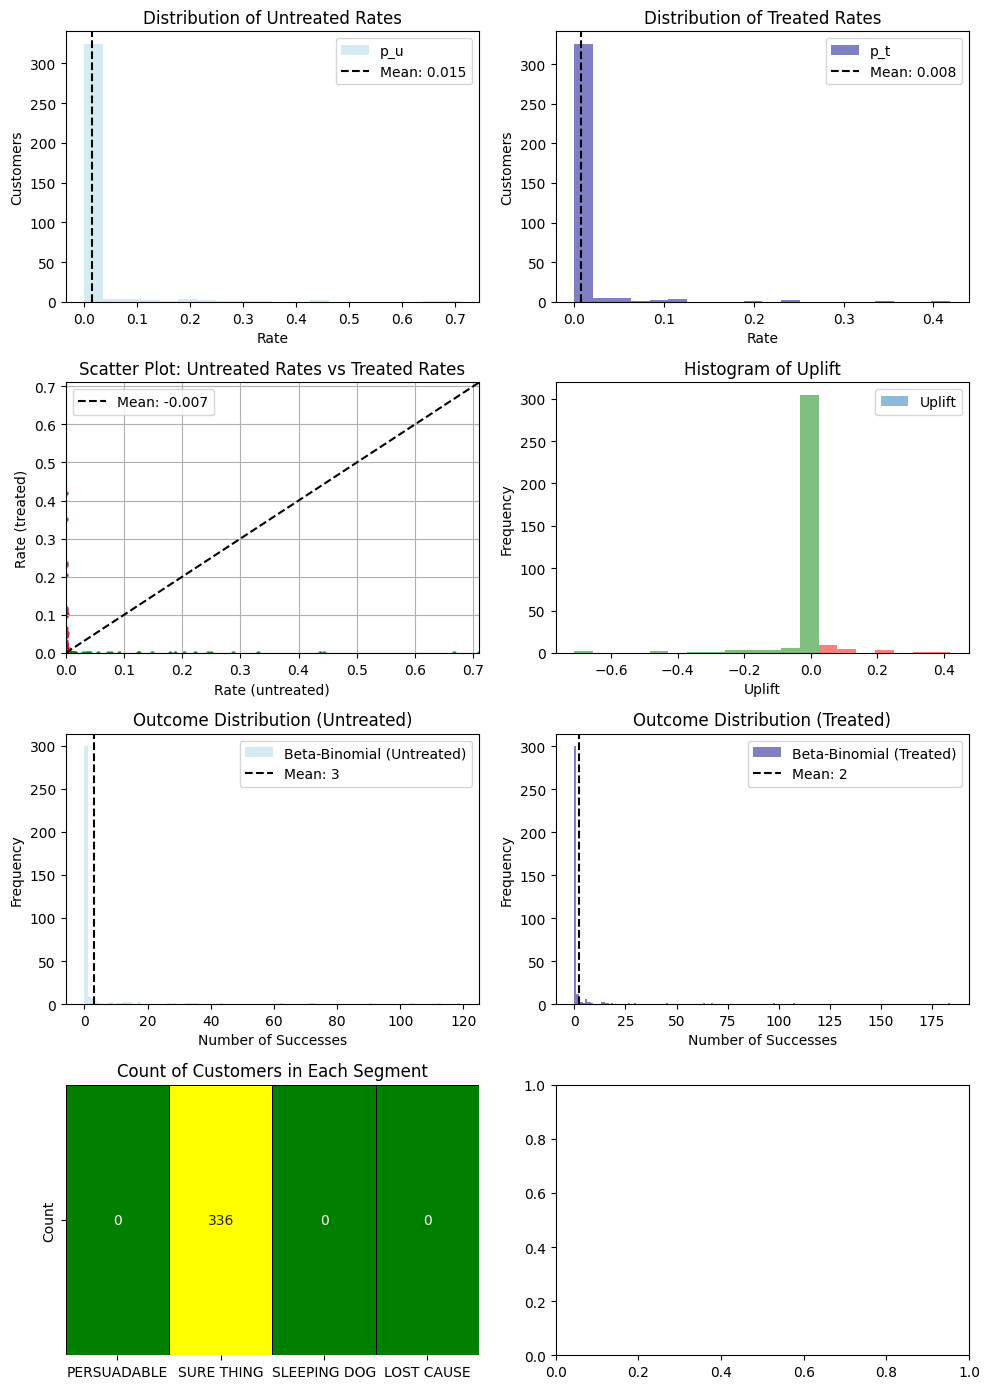

,untreated_churn_prob,treated_churn_prob,color
0,0.012583,0.000299,red
1,0.010432,0.000617,red
2,0.006896,0.000039,red
3,0.014847,0.000016,red
4,0.002701,0.000468,red


In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # Import seaborn for heatmap
from scipy.stats import beta, betabinom

def rate_uplift(p_u, b_u, p_t, b_t, N, rho=None, scatter=True, beta_binomial=True, gain=None, qini=None):
    # Create a figure with subplots
    fig, axs = plt.subplots(4, 2, figsize=(10, 14))  # Add one more row for the heatmap
    
    # Generate beta random variables with mean of p_u and standard deviation of b_u
    beta_p_u = np.random.beta(p_u, b_u, size=N)
    
    # Generate beta random variables with mean of p_t and standard deviation of b_t
    beta_p_t = np.random.beta(p_t, b_t, size=N)

    # Calculate uplift (treated rates - untreated rates)
    uplift = beta_p_t - beta_p_u

    df = pd.DataFrame({
        'beta_p_u': beta_p_u,
        'beta_p_t': beta_p_t,
        'uplift': uplift
    })

    # Create a new variable 'segment' based on conditions
    df['segment'] = 'UNKNOWN'  # Initialize with a default value

    # Set conditions and update 'segment' accordingly
    df.loc[(df['beta_p_u'] >= 0.8) & (df['beta_p_t'] <= 0.2), 'segment'] = 'PERSUADABLE'
    df.loc[(df['beta_p_u'] < 0.2) & (df['beta_p_t'] <= 0.8), 'segment'] = 'SURE THING'
    df.loc[(df['beta_p_u'] < 0.5) & (df['beta_p_t'] > 0.5), 'segment'] = 'SLEEPING DOG'
    df.loc[(df['beta_p_u'] >= 0.5) & (df['beta_p_t'] > 0.5), 'segment'] = 'LOST CAUSE'

    # Plot histogram of p_u (light blue)
    axs[0, 0].hist(beta_p_u, bins=20, alpha=0.5, label='p_u', color='lightblue')
    axs[0, 0].set_xlabel('Rate')
    axs[0, 0].set_ylabel('Customers')
    axs[0, 0].legend()
    axs[0, 0].set_title('Distribution of Untreated Rates')
    
    # Plot histogram of p_t (dark blue)
    axs[0, 1].hist(beta_p_t, bins=20, alpha=0.5, label='p_t', color='darkblue')
    axs[0, 1].set_xlabel('Rate')
    axs[0, 1].set_ylabel('Customers')
    axs[0, 1].legend()
    axs[0, 1].set_title('Distribution of Treated Rates')
    
    # Find the maximum value between p_u and p_t
    max_value = max(max(beta_p_u), max(beta_p_t))
    
    # Plot scatter plot of p_u (x) vs p_t (y) with scaled limits
    if scatter:
        axs[1, 0].scatter(beta_p_u, beta_p_t, s=5, alpha=0.5)
        axs[1, 0].set_xlabel('Rate (untreated)')
        axs[1, 0].set_ylabel('Rate (treated)')
        axs[1, 0].set_xlim(0, max_value)
        axs[1, 0].set_ylim(0, max_value)
        axs[1, 0].set_title('Scatter Plot: Untreated Rates vs Treated Rates')
        axs[1, 0].grid(True)
        
        # Draw the diagonal line
        axs[1, 0].plot([0, max_value], [0, max_value], color='black', linestyle='--')
        
        # Color points based on the condition p_t >= p_u or p_u > p_t
        for i in range(len(beta_p_u)):
            if beta_p_t[i] >= beta_p_u[i]:
                axs[1, 0].scatter(beta_p_u[i], beta_p_t[i], c='red', s=5, alpha=0.5)
            else:
                axs[1, 0].scatter(beta_p_u[i], beta_p_t[i], c='green', s=5, alpha=0.5)
    
    # Plot histogram of uplift in the bottom left corner
    axs[1, 1].hist(uplift, bins=20, alpha=0.5, label='Uplift')
    axs[1, 1].set_xlabel('Uplift')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].legend()
    axs[1, 1].set_title('Histogram of Uplift')
    
    # Color bars based on the condition uplift >= 0 or uplift < 0
    for bar in axs[1, 1].patches:
        if bar.get_x() >= 0:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('green')

    # Include Beta-binomial distribution if beta_binomial is True
    if beta_binomial:
        # Generate Beta-binomial samples
        bb_samples_u = betabinom.rvs(N, p_u, b_u, size=N)
        bb_samples_t = betabinom.rvs(N, p_t, b_t, size=N)
        
        # Determine the number of successes dynamically based on the max number of successes observed
        max_successes_u = max(bb_samples_u)
        max_successes_t = max(bb_samples_t)

        # Plot histograms of Beta-binomial samples for untreated (light blue) and treated (dark blue)
        axs[2, 0].hist(bb_samples_u, bins=range(max_successes_u + 2), alpha=0.5, label='Beta-Binomial (Untreated)', color='lightblue')
        axs[2, 0].set_xlabel('Number of Successes')
        axs[2, 0].set_ylabel('Frequency')
        axs[2, 0].legend()
        axs[2, 0].set_title('Outcome Distribution (Untreated)')
        
        axs[2, 1].hist(bb_samples_t, bins=range(max_successes_t + 2), alpha=0.5, label='Beta-Binomial (Treated)', color='darkblue')
        axs[2, 1].set_xlabel('Number of Successes')
        axs[2, 1].set_ylabel('Frequency')
        axs[2, 1].legend()
        axs[2, 1].set_title('Outcome Distribution (Treated)')

    # Calculate and add mean lines with labels to all histograms
    mean_p_u = np.mean(beta_p_u)
    mean_p_t = np.mean(beta_p_t)
    mean_uplift = np.mean(uplift)
    mean_bb_u = np.mean(bb_samples_u)
    mean_bb_t = np.mean(bb_samples_t)
    
    axs[0, 0].axvline(mean_p_u, color='black', linestyle='--', label=f'Mean: {mean_p_u:.3f}')
    axs[0, 0].legend()
    
    axs[0, 1].axvline(mean_p_t, color='black', linestyle='--', label=f'Mean: {mean_p_t:.3f}')
    axs[0, 1].legend()
    
    axs[1, 0].axvline(mean_uplift, color='black', linestyle='--', label=f'Mean: {mean_uplift:.3f}')
    axs[1, 0].legend()
    
    if beta_binomial:
        axs[2, 0].axvline(mean_bb_u, color='black', linestyle='--', label=f'Mean: {mean_bb_u:.0f}')
        axs[2, 0].legend()
        
        axs[2, 1].axvline(mean_bb_t, color='black', linestyle='--', label=f'Mean: {mean_bb_t:.0f}')
        axs[2, 1].legend()


    # Assuming df and axs are defined elsewhere in your code
    segments = ['PERSUADABLE', 'SURE THING', 'SLEEPING DOG', 'LOST CAUSE']
    segment_counts = [len(df[df['segment'] == s]) for s in segments]
    segment_colors = ['green', 'lightgreen', 'red', 'yellow']  # Define segment colors

    # Updated heatmap function to avoid scientific notation
    sns.heatmap(np.array([segment_counts]), annot=True, fmt='d', cmap=segment_colors, cbar=False, ax=axs[3, 0], linewidths=0.5, linecolor='black')
    axs[3, 0].set_xticklabels(segments)
    axs[3, 0].set_yticklabels(['Count'])
    axs[3, 0].set_title('Count of Customers in Each Segment')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the subplots
    plt.show()

# Example usage with b_u and b_t, including Beta-binomial
rate_uplift(p_u=0.03, b_u=2.50, p_t=0.03, b_t=5.00, N=346, beta_binomial=True)

df.head()


### LTV Uplift

LTV uplift (incremental revenue $) is the different between LTV of the treatment and the LTV of the BAU non-treatment scenario.
$$LTV_{\pi} = LTV_T - LTV_C $$

**Non-treatment Scenario**

In the non-treatment scenario, our churn targeting is not precise (only correctly identifying 20% of churners correctly, i.e. a lot of sure things) 

$$ LTV_{C} = N \alpha \left( 
   \left( \beta_{C} (\gamma  - \eta (1-\gamma)) + (1 - \beta_{C}) \psi \Delta \right) \times CLV - \delta \left(\beta_{C} \gamma + (1 - \beta_{C}) \psi \right) - c
  \right) 
$$

**Treatment Scenario**

In the treatment scenario, our targeting becomes 3.6x more accurate, mainly identifying persuadables.

$$ LTV_{T} = N \alpha \left( 
   \left( \beta_{T} (\gamma  - \eta (1-\gamma)) + (1 - \beta_{T}) \psi \Delta \right) \times CLV - \delta \left(\beta_{T} \gamma + (1 - \beta_{T}) \psi \right) - c
  \right) 
$$

- $N$ = total customers = $346$
- $\alpha$ = % of customers that are targeted = $17\%$
- $\beta$ = precision of churn targeting = $20\%$ (moving to $92\%$)
- $c$ = cost of contacting a customer = $\$100$ in labour
- $\gamma$ = probability an identified churner is retained = $33\%$
- $(1 - \gamma$) = probability an identified churner isn't retained = $33\%$
- $\eta$ = probability of a sleeping dog amongst identified churners that aren't retained = $10\%$
- $\psi$ = probability a non-churner takes the call and incentive = $100\%$ (would be irrational not to)
- $\Delta$ = lift in LTV of non-churners who take the call and incentive/free offer ($0\%$)
- $\delta$ = the cost of the incentive = $0$
- $LTV$ = current customer lifetime value = $191000$

### Upper bound on $\alpha$

Let the baseline untreated churn propensity be $C_u$. $C_u = 12, as 

Under the status quo, we contact 17% of the base, when 12% of the base churns per year (around 1% each month).

$$ N \cdot \alpha \cdot \beta = C_u $$
$$ 1 \cdot 0.17 \cdot 0.2 = 0.03 $$




In [3]:
# Complete code with number of customers in print statements
def calculate_retention_uplift(N, alpha, beta, c, gamma, eta, psi, Delta, delta, LTV):
    r_pi = N * alpha * (
        ((beta * (gamma - eta * (1 - gamma)) + (1 - beta) * psi * Delta) * LTV) 
        - delta * (beta * gamma + (1 - beta) * psi) 
        - c
    )
    return r_pi

# Example usage with beta_1 and beta_2
N = 346 # Total customers
LTV = 190674  
alpha_1 = 0.17  # Contact rate for scenario 1
alpha_2 = 0.17  # Contact rate for scenario 2
beta_1 = 0.2  # Precision 1
beta_2 = 0.92  # Precision 2
eta = 0.1  # Probability of waking a sleeping dog
c = 100  # Cost per contact
delta = 0  # Cost per incentive
gamma = 0.33  # Rescue rate
psi = 1.00  # Non-churner incentive acceptance
Delta = 0.05  # LTV lift from non-churner incentive acceptance

uplift_beta_1 = calculate_retention_uplift(N, alpha_1, beta_1, c, gamma, eta, psi, Delta, delta, LTV)
uplift_beta_2 = calculate_retention_uplift(N, alpha_2, beta_2, c, gamma, eta, psi, Delta, delta, LTV)

# Print formatted values with number of customers
print("CURRENT RETENTION PROGRAM")
print(f"Total LTV: ${N * LTV:,.0f} ({N})")
print(f"Total LTV of contacted: ${N * LTV * alpha_1:,.0f} ({round(N * alpha_1)})")
print(f"Total LTV of contacted churners: ${N * LTV * alpha_1 * beta_1:,.0f} ({round(N * alpha_1 * beta_1)})")
print(f"Total LTV gain from rescuing persuadables: ${N * LTV * alpha_1 * beta_1 * gamma:,.0f} ({round(N * alpha_1 * beta_1 * gamma)})")
print(f"Total LTV loss from waking sleeping dogs: ${N * LTV * alpha_1 * beta_1 * (1-gamma) * eta:,.0f} ({round(N * alpha_1 * beta_1 * (1-gamma) * eta)})")
print(f"Cost of contact: ${N * alpha_1 * c:,.0f} ({round(N * alpha_1)})")
print(f"Cost of incentives: ${N * alpha_1 * beta_1 * (1 - beta_1) * psi * delta:,.0f} ({round(N * alpha_1 * beta_1 * (1 - beta_1) * psi)})")
print(f"Total LTV from delighted non-churners: ${N * LTV * alpha_1 * (1 - beta_1) * psi * Delta:,.0f} ({round(N * alpha_1 * (1 - beta_1) * psi)})")
print(f"Retention program with original precision (20%): ${uplift_beta_1:,.0f}")

print()

print("IMPROVED RETENTION PROGRAM")
print(f"Total LTV: ${N * LTV:,.0f} ({N})")
print(f"Total LTV of contacted: ${N * LTV * alpha_2:,.0f} ({round(N * alpha_2)})")
print(f"Total LTV of contacted churners: ${N * LTV * alpha_2 * beta_2:,.0f} ({round(N * alpha_2 * beta_2)})")
print(f"Total LTV gain from rescuing persuadables: ${N * LTV * alpha_2 * beta_2 * gamma:,.0f} ({round(N * alpha_2 * beta_2 * gamma)})")
print(f"Total LTV loss from waking sleeping dogs: ${N * LTV * alpha_2 * beta_2 * (1-gamma) * eta:,.0f} ({round(N * alpha_2 * beta_2 * (1-gamma) * eta)})")
print(f"Cost of contact: ${N * alpha_2 * c:,.0f} ({round(N * alpha_2)})")
print(f"Cost of incentives: ${N * alpha_2 * beta_2 * (1 - beta_2) * psi * delta:,.0f} ({round(N * alpha_2 * beta_2 * (1 - beta_2) * psi)})")
print(f"Total LTV from delighted non-churners: ${N * LTV * alpha_2 * (1 - beta_2) * psi * Delta:,.0f} ({round(N * alpha_2 * (1 - beta_2) * psi)})")
print(f"Retention program with new precision (92%): ${uplift_beta_2:,.0f}")

print()

print(f"Total LTV uplift $ from data model: ${uplift_beta_2 - uplift_beta_1:,.0f}")
print(f"Total LTV uplift % from data model: {((uplift_beta_2 - uplift_beta_1) / (N * LTV) * 100):,.2f}%")


CURRENT RETENTION PROGRAM
Total LTV: $65,973,204 (346)
Total LTV of contacted: $11,215,445 (59)
Total LTV of contacted churners: $2,243,089 (12)
Total LTV gain from rescuing persuadables: $740,219 (4)
Total LTV loss from waking sleeping dogs: $150,287 (1)
Cost of contact: $5,882 (59)
Cost of incentives: $0 (9)
Total LTV from delighted non-churners: $448,618 (47)
Retention program with original precision (20%): $1,032,668

IMPROVED RETENTION PROGRAM
Total LTV: $65,973,204 (346)
Total LTV of contacted: $11,215,445 (59)
Total LTV of contacted churners: $10,318,209 (54)
Total LTV gain from rescuing persuadables: $3,405,009 (18)
Total LTV loss from waking sleeping dogs: $691,320 (4)
Cost of contact: $5,882 (59)
Cost of incentives: $0 (4)
Total LTV from delighted non-churners: $44,862 (5)
Retention program with new precision (92%): $2,752,669

Total LTV uplift $ from data model: $1,720,001
Total LTV uplift % from data model: 2.61%


# Solution: Classification model


Gradient boosting is a machine learning technique commonly used for binary classification tasks like churn prediction. It builds a predictive model in a stage-wise fashion and is optimized for a binary classification loss function.

**Basic Idea for Binary Classification**:
- Aim: Predict whether a customer will churn (1) or not (0).
- Combine several weak predictive models (typically decision trees) to create a strong predictive model.

**xgBoost explained**:
- Each decision tree in the ensemble focuses on the customers that previous trees predicted incorrectly.
- The loss function typically used is the logistic loss, which is suitable for binary outcomes.
- Regularization techniques (like controlling the number of trees, tree depth, and learning rate) are crucial to avoid overfitting.
- The output can be transformed into a probability of churn using the logistic function.

**Algorithm**:
1. Initialize the model with a constant value:
   $$ F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, \gamma) $$
   where $F_0$ is the initial model, $L$ is the binary classification loss function (like logistic loss), $y_i$ are the true binary labels, and $N$ is the number of data points.

2. For each stage $m = 1$ to $M$ (where $M$ is the number of boosting stages):
   a. Compute the negative gradient (pseudo-residuals) for the binary classification loss function:
      $$ r_{im} = -\left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)} \quad \text{for } i=1,2,\dots,N $$
   b. Fit a weak learner (e.g., a decision tree) to these pseudo-residuals.
   c. Compute the multiplier $\gamma_m$ for the weak learner by solving:
      $$ \gamma_m = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)) $$
      where $h_m(x_i)$ is the weak learner.
   d. Update the model:
      $$ F_m(x) = F_{m-1}(x) + \gamma_m h_m(x) $$

3. The final model is:
   $$ F_M(x) = F_0(x) + \sum_{m=1}^{M} \gamma_m h_m(x) $$



# Data required

### $y$-variable
- Churn status [bool]


### $x$-variables

**Billing information**
- Product [str]
- Annual billing cadence [bool]
- Seats [int]
- % Expansion [float]
- Duration (current if live, until churn date if churned) [int]

**Product RFM data**
- Frequency [float] (average count per day): Projects, Transcriptions, Notes, Highlights, Tags, Comments, Invites, Shared Objects, Reels, Reel Views
- Recency [int] (days since last activity): Projects, Transcriptions, Notes, Highlights, Tags, Comments, Invites, Shared Objects, Reels, Reel Views
- MRR [float]

Recency and frequency data should sample a specific period.

*Monthly Customers:* 
- If churned, converted date to churn date - 15 days
- If retained, converted date to min(current_date, next renewal date - 15 days)


$$\text{Data period starts}_m = \text{Conversion date}_m$$
$$\text{Data period ends}_m = \min(\text{Current date}, \text{Next renewal date - 15}_m)$$

*Monthly Customers:* 
- If churned, converted date to churn date - 90 days
- If retained, converted date to min(current_date, next renewal date - 90 days)


$$\text{Data period starts}_a = \text{Conversion date}_a$$
$$\text{Data period ends}_a = \min(\text{Current date}, \text{Next renewal date - 90}_a)$$

### Additional features
- ID
- Name
- Next billing date (if applicable)

# Import

In [ ]:
def import_data_local_csv():
    import pandas as pd
    file_path = '/Users/patricksweeney/growth/04_Retention/04_Nonparametric churn prediction/Retention training.csv'
    data = pd.read_csv(file_path)
    return data

#Import
data = import_data_local_csv()
data.head()

In [ ]:
def drop_variables(data, variables):
    # Ensure 'variables' is a list
    if not isinstance(variables, list):
        raise ValueError("The 'variables' parameter should be a list of column names.")

    # Drop the specified columns
    data = data.drop(columns=variables, errors='ignore')

    return data

data = drop_variables(data, ['t'])
data.head()

# Filter out Enterprise

In [ ]:
import pandas as pd

def filter_and_count(data):
    # Filter data to include only where 'product' equals 'Business' or 'Enterprise'
    filtered_data = data[data['product'].isin(['Business', 'Enterprise'])]

    # Count the number of rows where 'churned' equals 1
    churn_count = filtered_data[filtered_data['churned'] == 1].shape[0]

    # Print the count
    print(f"Count of rows where churned = 1: {churn_count}")

    return filtered_data

data = filter_and_count(data)
data.head()

# Check data

In [ ]:
def find_missing_values(data):
    missing_values = data.isnull().sum()
    print("Features with missing values are...")
    print(missing_values)

find_missing_values(data)

In [ ]:
def impute_missing_values(data):
    import numpy as np
    import pandas as pd
    from sklearn.impute import SimpleImputer

    # Create an imputer instance with median strategy
    imputer = SimpleImputer(strategy='median')

    # Extract numerical columns
    data_num = data.select_dtypes(include=[np.number])

    # Fit the imputer to the numerical data
    imputer.fit(data_num)

    # Transform the numerical data with the imputer
    data_num_imputed = imputer.transform(data_num)

    # Convert the imputed data back to a DataFrame
    data_num_imputed_df = pd.DataFrame(data_num_imputed, columns=data_num.columns)

    # Replace the original numerical columns with the imputed ones
    data[data_num.columns] = data_num_imputed_df

    return data


#Preprocess
data = impute_missing_values(data)
data.head()


# Feature engineering

In [ ]:
def one_hot_encode(data, variables):
    import pandas as pd
    # Check if the input is a list of variables. If not, convert it to a list
    if not isinstance(variables, list):
        variables = [variables]
    # Perform one-hot encoding only on the specified variables
    for var in variables:
        if var in data.columns:
            # Get one-hot encoded dataframe with numeric type and drop the original column
            one_hot = pd.get_dummies(data[var], prefix=var, dtype=int)
            data = data.drop(var, axis=1)
            data = data.join(one_hot)
    return data

# Variables to one-hot encode
variables_to_encode = ['product', 'annual']


data = one_hot_encode(data, variables_to_encode)
data.head()

# Train and test Gradient Boosting

In [ ]:
def gradient_boosting(data, y_variable):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, cohen_kappa_score, brier_score_loss
    from sklearn.calibration import calibration_curve
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    random_state = 1

    # Separate the features and target variable (also drop not numeric X features)
    X = data.drop(columns=[y_variable]).select_dtypes(include=np.number)
    y = data[y_variable]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # 1. Train model
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)

    # 2. Test model
    cv = StratifiedKFold(n_splits=10)
    cross_val_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
    print("Cross-validation scores:", cross_val_scores)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 3. Calibration plot
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, "s-")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("True Probability")
    plt.title("Calibration Plot")
    plt.show()

    # 4. Classification report
    print(classification_report(y_test, y_pred))

    # 5. Confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 6. ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # 7. Precision recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # 8. Cross-validation score
    print("Average cross-validation score:", np.mean(cross_val_scores))

    # 11. Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # 11.5 Brier Score
    brier_score = brier_score_loss(y_test, y_proba)
    print(f"Brier Score: {brier_score}")
    
    return model

model = gradient_boosting(data, 'churned')

# Save model

In [ ]:
def save_model(model, filename):
    import pickle
    with open(filename, 'wb') as file:
         pickle.dump(model, file)

In [ ]:
def save_model_joblib(model, filename):
    import joblib
    # Save the model using joblib
    joblib.dump(model, filename)

# Return predictions

In [ ]:
def get_predictions(data, model, y_variable):
    import pandas as pd
    import numpy as np

    # Filter data where churn equals 0
    churn_data = data[data[y_variable] == 0]

    # Separate the features and retain the index
    X_churn = churn_data.drop(columns=[y_variable]).select_dtypes(include=np.number)

    # Make predictions
    predictions = model.predict(X_churn)
    probabilities = model.predict_proba(X_churn)[:, 1]

    # Append predictions and probabilities to the original data
    data.loc[churn_data.index, 'Prediction'] = predictions
    data.loc[churn_data.index, 'Probability'] = probabilities

    # Calculate and append the 'value_at_risk' by multiplying MRR with Probability
    # Replace 'MRR' with the actual name of your MRR column in the data
    data.loc[churn_data.index, 'value_at_risk'] = data.loc[churn_data.index, 'mrr'] * 12 * data.loc[churn_data.index, 'Probability']

    return data

In [ ]:
def save_predictions(predictions, filename):
    import pandas as pd

    # Ensure the filename ends with '.xlsx'
    if not filename.endswith('.xlsx'):
        filename += '.xlsx'

    # Save to Excel
    predictions.to_excel(filename, index=False)

# Main

**Precision** of churn is the percentage of identified churners who actually churn.

**Recall** is the percenters of churners who are identified.

**Cohen's kappa** quantifies the agreement between the predictions and the actual outcomes, correcting for chance agreement.

**Brier score** is the mean squared difference between predicted probabilities and the actual outcomes

In [76]:
#Import
data = import_data_local_csv()
data = drop_variables(data, ['t'])
data = filter_and_count(data)

#Preprocess
# data = impute_missing_values(data)
data = one_hot_encode(data, variables_to_encode)
data.head()


Count of rows where churned = 1: 42


,workspace_id,mrr_converted,mrr,expansion,churned,start_date,end_date,project_count_r,transcription_count_r,note_count_r,...,page_user_count_f,shared_object_note_count_f,shared_object_highlight_count_f,shared_object_tag_count_f,shared_object_insight_count_f,comment_count_f,reel_viewed_count_f,product_Business,product_Enterprise,annual_1
21,ec6836e7-dd54-4783-bc5e-78d294466045,4200.0,5080.0,0.209524,0,2022-08-25,2024-01-04,2.0,7.0,2.0,...,4.416499,0.058350,0.008048,0.010060,0.193159,0.0,0.237425,0,1,1
48,cdb36931-c8dd-4f7c-bedc-8d1e1f4d9b42,4200.0,14100.0,2.357143,0,2022-06-13,2024-01-04,9.0,13.0,2.0,...,8.882456,0.463158,0.035088,0.121053,0.117544,0.0,0.338596,0,1,1
57,06e70382-2e89-45d7-863d-5f9fafe905ab,45.0,900.0,19.000000,0,2022-01-10,2024-01-04,1.0,17.0,1.0,...,3.244475,0.098066,0.012431,0.024862,0.060773,0.0,0.200276,1,0,1
95,a1949be4-2dfe-41b2-b97b-1859db17ee8e,900.0,900.0,0.000000,0,2021-08-19,2024-01-04,22.0,72.0,7.0,...,0.631651,0.008186,0.012278,0.000000,0.010914,0.0,0.098226,1,0,1
130,6478fd14-e3ce-42a1-8276-726f74534462,390.0,60.0,-0.846154,0,2023-01-30,2024-01-04,15.0,14.0,14.0,...,1.646018,0.129794,0.032448,0.230088,0.002950,0.0,0.079646,1,0,1


Cross-validation scores: [1.         0.95121951 0.92682927 0.97560976 1.         1.
 0.95       1.         0.95       0.95      ]


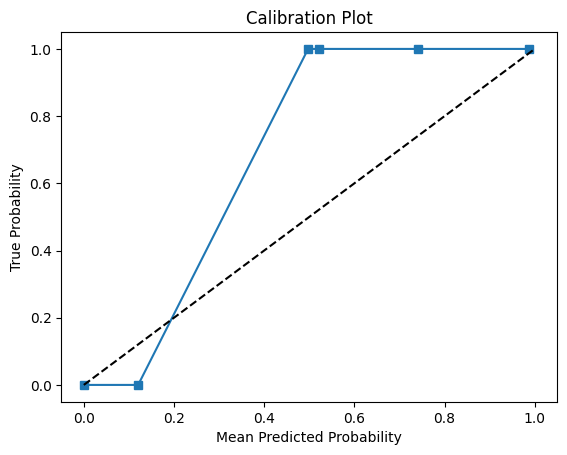

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      0.91      0.95        11

    accuracy                           0.99        82
   macro avg       0.99      0.95      0.97        82
weighted avg       0.99      0.99      0.99        82

Confusion matrix:
[[71  0]
 [ 1 10]]


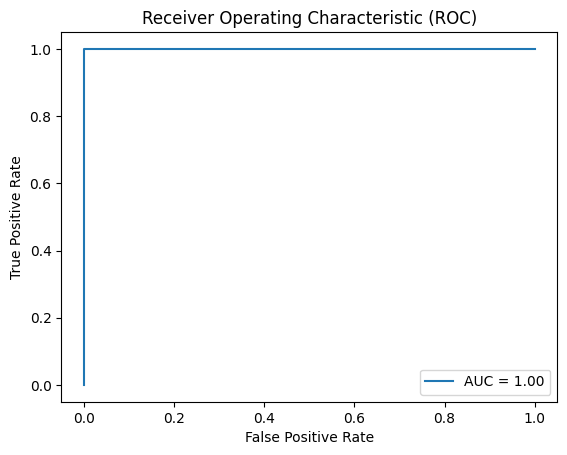

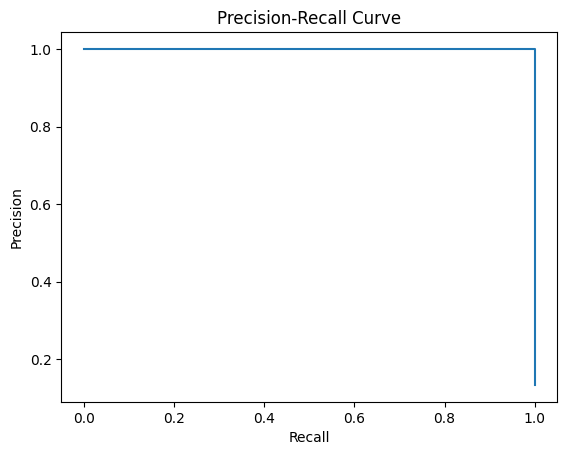

Average cross-validation score: 0.9703658536585366
Cohen's Kappa: 0.9454061251664447
Brier Score: 0.006915073827175462


In [77]:

#Train and test
model = gradient_boosting(data, 'churned')

#Predict
predictions = get_predictions(data, model, 'churned')

#Save
save_model(model, 'gradient_boosting_churn.pkl')
save_model_joblib(model, 'gradient_boosting_churn.joblib')

save_predictions(predictions, 'predictions.xlsx')